In [1]:
%matplotlib inline
# matplotlib widget doesn't seem to work
# %matplotlib widget
import sys
import math
import logging
import numpy as np
import psycopg2
import psycopg2.extras
from matplotlib import pyplot

from desi_specinfo import TargetNotFound, SpectrumInfo

logger = logging.getLogger("main")
ch = logging.StreamHandler(sys.stderr)
logger.addHandler(ch)
formatter = logging.Formatter(
    f"[%(asctime)s - %(levelname)s] - %(message)s"
)
ch.setFormatter(formatter)
logger.setLevel( logging.INFO )

In [2]:
# Replace these next two lines with something that sets dbpasswd to the
#  right value.  It can be as simple as
#    dbpasswd = '...'
#  with the right thing in place of ...
with open("/global/homes/r/raknop/secrets/decatdb_desi_desi") as ifp:
    (dbuser,dbpasswd) = ifp.readline().strip().split()

In [3]:
# Put the name (from the "snname" column") of the MostHosts supernova you want to poke at
mosthost_name = 'ZTF18aakjgzb'

desidb = psycopg2.connect( dbname='desi', host='decatdb.lbl.gov', user='desi', password=dbpasswd,
                           cursor_factory=psycopg2.extras.RealDictCursor )
q = "SELECT ra,dec FROM mosthosts.mosthosts WHERE snname=%(snname)s"
cursor = desidb.cursor()
logger.debug( f'Running query : {cursor.mogrify(q, { "snname": mosthost_name })}' )
cursor.execute( q, { "snname": mosthost_name } )
rows = cursor.fetchall()
cursor.close()
desidb.close()
if len(rows) == 0:
    raise Exception( f'{mosthost_name} not found in mosthosts' )
print( f'{mosthost_name} has {len(rows)} entries in the MostHosts table' )

allhostdata = []

logger.info( 'Looking for DESI data on hosts...' )
for num, row in enumerate( rows ):
    ra = row['ra']
    dec = row['dec']
    try:
        specinfo = SpectrumInfo( ra, dec, desipasswd=dbpasswd, logger=logger )
    except TargetNotFound as ex:
        logger.error( f'No everest spectra found for host {num} of {mosthost_name} at ({ra:.4f}, {dec:.4f})' )
        continue
    allhostdata.append( specinfo )
    print( f'Host: ra = {ra:.5f}, dec = {dec:.5f}' )
    print( f'  {len(specinfo.targetids)} DESI targets in everest' )
    for targetid in specinfo.targetids:
        targetinfo = specinfo.info_for_targetid( targetid )
        for info in targetinfo:
            print( f'    targetid={targetid}, tileid={info["tileid"]}, petal_loc={info["petal_loc"]}, '
                   f'device_loc={info["device_loc"]}, night={info["night"]}, z={info["z"]:03f}±{info["zerr"]:03f}, '
                   f'zwarn={info["zwarn"]}' )
            print( f'      filename={info["filename"]}' )
logger.info( 'Done looking for everest data on hosts.' )
print( f'Found spectra of {len(allhostdata)} hosts for {mosthost_name}' )
                         


[2021-10-22 12:07:43,046 - INFO] - Looking for DESI data on hosts...
[2021-10-22 12:07:43,060 - INFO] - Looking for daily spectra at (240.5221, 55.2009)
[2021-10-22 12:07:43,080 - INFO] - Done looking for daily spectra at (240.5221, 55.2009)
[2021-10-22 12:07:43,093 - INFO] - Looking for daily spectra at (240.5238, 55.2036)
[2021-10-22 12:07:43,113 - INFO] - Done looking for daily spectra at (240.5238, 55.2036)
[2021-10-22 12:07:43,117 - INFO] - Done looking for everest data on hosts.


ZTF18aakjgzb has 2 entries in the MostHosts table
Host: ra = 240.52207, dec = 55.20090
  1 DESI targets in everest
    targetid=39633325924550913, tileid=309, petal_loc=3, device_loc=357, night=20210407, z=0.092228±0.000026, zwarn=0
      filename=/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/309/20210407/coadd-3-309-thru20210407.fits
Host: ra = 240.52378, dec = 55.20360
  1 DESI targets in everest
    targetid=39633325924550937, tileid=312, petal_loc=3, device_loc=278, night=20210416, z=0.093658±0.000006, zwarn=0
      filename=/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/312/20210416/coadd-3-312-thru20210416.fits
    targetid=39633325924550937, tileid=316, petal_loc=3, device_loc=264, night=20210429, z=0.093647±0.000005, zwarn=0
      filename=/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/316/20210429/coadd-3-316-thru20210429.fits
Found spectra of 2 hosts for ZTF18aakjgzb


/global/u1/r/raknop/jupyter/mosthosts/desi_specinfo.py:263: RuntimeWarning: divide by zero encountered in true_divide
  dflux = 1./np.sqrt( hdulist[f'{λrange}_IVAR'].data[index] )


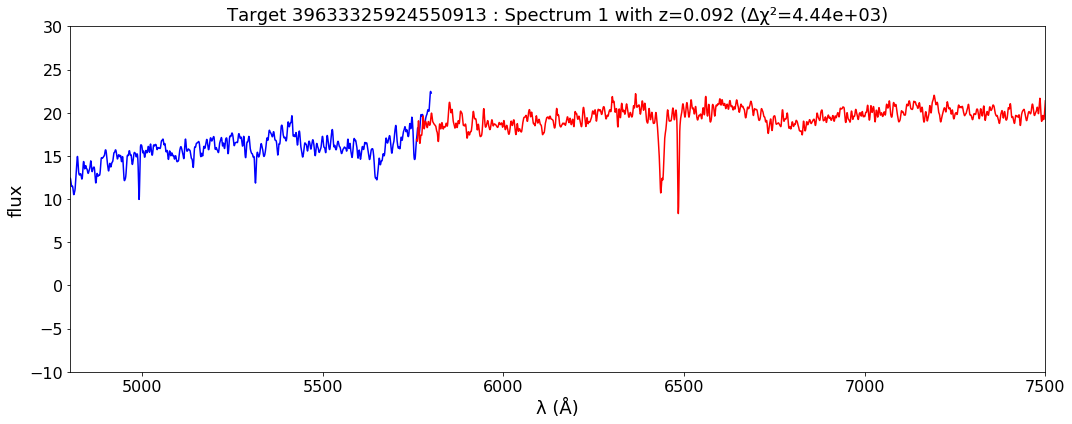

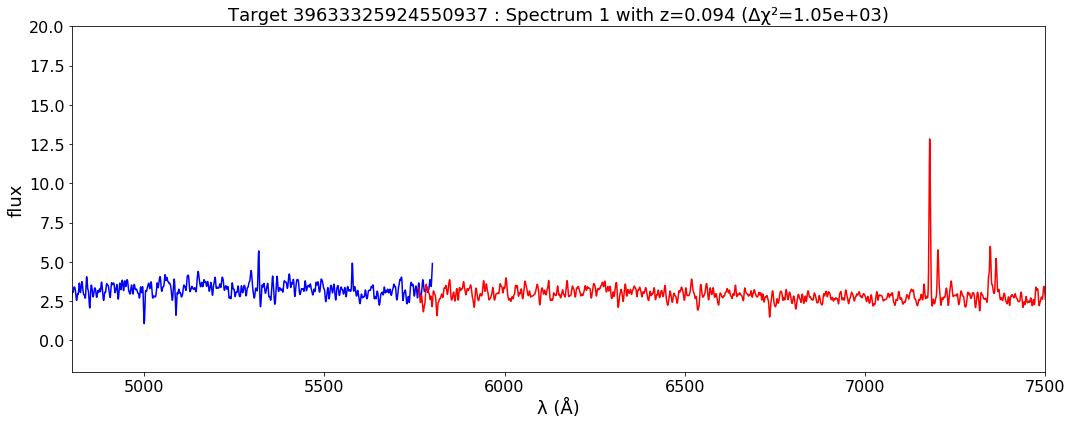

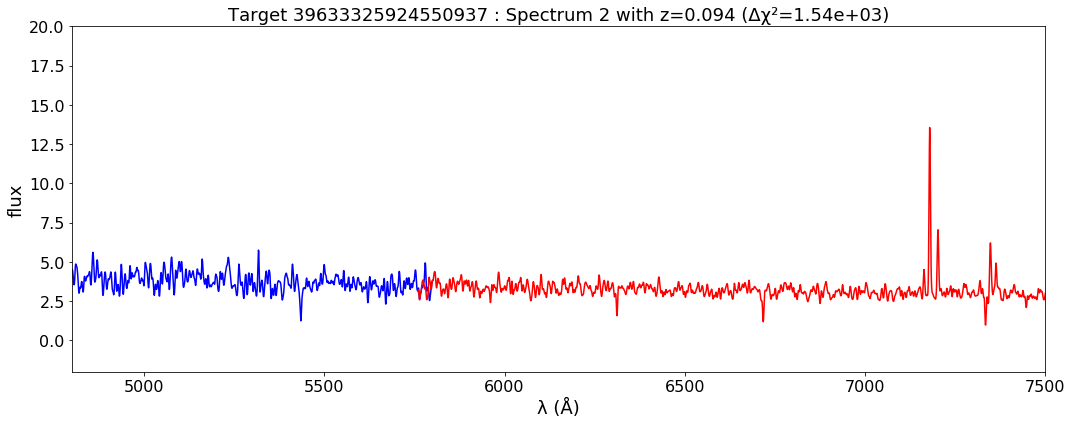

In [4]:
# Plot limits; array, one for each target (not spectrum).  Make them all None to autoscale.
fmin = [-10, -2] # None # [-3, 0 ]
fmax = [30, 20] # None # [ 3, 50 ]
λmin = 4800
λmax = 7500
gausssmooth = 2

plotcolors = { 'B': 'b',
               'R': 'r',
               'Z': 'saddlebrown' }

targnum = -1
for hostcollection in allhostdata:
    for targetid in hostcollection.targetids:
        targnum += 1
        spectra = hostcollection.get_spectra( targetid, smooth=gausssmooth )
        specnum = 0
        for spec in spectra:
            specnum += 1
            fig = pyplot.figure( figsize=(15,6), tight_layout=True )
            ax = fig.add_subplot( 1, 1, 1 )
            title = ( f'Target {targetid} : Spectrum {specnum} '
                      # f'Tile {spec["tileid"]} on night {spec["night"]} '
                      f'with z={spec["info"]["z"]:.3f}' )
            if spec["info"]["zwarn"] != 0:
                title += f' (zwarn={spec["info"]["zwarn"]})'
            title += f' (Δχ²={spec["info"]["deltachi2"]:.3g})'
            ax.set_title( title, fontsize=18 )
            ax.set_xlabel( 'λ (Å)', fontsize=18 )
            ax.set_ylabel( 'flux', fontsize=18 )
            ax.tick_params( axis='both', labelsize=16 )
            if λmin is not None:
                if isinstance(λmin, list):
                    ax.set_xlim( λmin[targnum], λmax[targnum] )
                else:
                    ax.set_xlim( λmin, λmax )
            if fmin is not None:
                if isinstance(fmin, list):
                    ax.set_ylim( fmin[targnum], fmax[targnum] )
                else:
                    ax.set_ylim( fmin, fmax )
            for λrange in ['B','R','Z']:
                λ = spec[f'{λrange}_wavelength']
                flux = spec[f'{λrange}_flux']
                ax.plot( λ, flux, color=plotcolors[λrange] )
            fig.show()
